<a href="https://colab.research.google.com/github/Han1018/Cryptocurrency-Automated-Trading/blob/backtrader/backtradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install flask-ngrok
# !pip install -U flask-cors


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/CloudProJ') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# client.list("/")

In [ ]:
import pandas as pd
import base64
import time
import matplotlib.pyplot as plt
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import json
from flask_cors import CORS
import matplotlib.image as mpimg # mpimg 用于读取图片
app = Flask(__name__)
run_with_ngrok(app)
CORS(app)


df_stock_doge = pd.read_csv('DOGEUSDT_250k.csv')
df_stock_btc = pd.read_csv('BTCUSDT_870k.csv')
df_stock_etc = pd.read_csv('ETHUSDT_750k.csv')
df_stock_doge=df_stock_doge.drop(columns=['json_parse'])
df_stock_btc=df_stock_btc.drop(columns=['json_parse'])
df_stock_etc=df_stock_etc.drop(columns=['json_parse'])

### 移動平均線
- min5
- min10
- min30
- 1h/min60
- 3h/min180


In [ ]:
df_stock_doge['min5'] = df_stock_doge['close'].rolling(window=5).mean()
df_stock_btc['min5'] = df_stock_btc['close'].rolling(window=5).mean()
df_stock_etc['min5'] = df_stock_etc['close'].rolling(window=5).mean()

df_stock_doge['min10'] = df_stock_doge['close'].rolling(window=10).mean()
df_stock_btc['min10'] = df_stock_btc['close'].rolling(window=10).mean()
df_stock_etc['min10'] = df_stock_etc['close'].rolling(window=10).mean()

df_stock_doge['min30'] = df_stock_doge['close'].rolling(window=30).mean()
df_stock_btc['min30'] = df_stock_btc['close'].rolling(window=30).mean()
df_stock_etc['min30'] = df_stock_etc['close'].rolling(window=30).mean()

df_stock_doge['1h'] = df_stock_doge['close'].rolling(window=60).mean() 
df_stock_btc['1h'] = df_stock_btc['close'].rolling(window=60).mean() 
df_stock_etc['1h'] = df_stock_etc['close'].rolling(window=60).mean() 

df_stock_doge['3h'] = df_stock_doge['close'].rolling(window=180).mean()
df_stock_btc['3h'] = df_stock_btc['close'].rolling(window=180).mean()
df_stock_etc['3h'] = df_stock_etc['close'].rolling(window=180).mean()


### 計算BIAS乖離率

In [ ]:
# df_stock['BIAS5'] = (df_stock['close'] - df_stock['min5']) / df_stock['min5']
# df_stock['BIAS10'] = (df_stock['close'] - df_stock['min10']) / df_stock['min10']
# df_stock.head()

### 最佳買點 : 
1. 成交量比前一天大 & 收盤價比前一天高
2. 成交量比前一天小 & 收盤價比前一天高
3. MA5線比前一天高 & 前一天MA5線比前兩天MA5線高(連漲兩個5分線)
4. MA5>MA10

In [ ]:
# df_stock['BestBuy1'] = ((df_stock['Volume'] > df_stock['Volume'].shift(1)) & (df_stock['Close'] > df_stock['Close'].shift(1)))
# df_stock['BestBuy2'] = ((df_stock['Volume'] < df_stock['Volume'].shift(1)) & (df_stock['Close'] > df_stock['Close'].shift(1)))
# df_stock['BestBuy3'] = ((df_stock['MovingAverage5'] > df_stock['MovingAverage5'].shift(1))& (df_stock['MovingAverage5'].shift(1) > df_stock['MovingAverage5'].shift(2)))
# df_stock['BestBuy4'] = df_stock['MovingAverage5'] > df_stock['MovingAverage10']
# df_stock['buy'] = (df_stock['min5'] > df_stock['min10'])

### 最佳賣點

In [ ]:
# stock['BestSell1'] = ((stock['Volume'] > stock['Volume'].shift(1)) 
#                      & (stock['Close'] < stock['Close'].shift(1)))
# stock['BestSell2'] = ((stock['Volume'] < stock['Volume'].shift(1)) 
#                      & (stock['Close'] < stock['Close'].shift(1)))
# stock['BestSell3'] = ((stock['MovingAverage5'] < stock['MovingAverage5'].shift(1))
#                      & (stock['MovingAverage5'].shift(1) < stock['MovingAverage5'].shift(2)))
# stock['BestSell4'] = stock['MovingAverage5'] < stock['MovingAverage10']

去除NaN

In [ ]:
df_stock_etc=df_stock_etc.dropna()
df_stock_btc=df_stock_btc.dropna()
df_stock_doge=df_stock_doge.dropna()

df_stock_etc.index=range(len(df_stock_etc))
df_stock_btc.index=range(len(df_stock_btc))
df_stock_doge.index=range(len(df_stock_doge))


### 校正min5/min10/上一個收盤價..位置

In [ ]:
def MoveDownMinAndPriceForStrategy(df_stock):
  df_stock['min5']=df_stock['min5'].shift(1)
  df_stock['min10']=df_stock['min10'].shift(1)
  df_stock['min30']=df_stock['min30'].shift(1)
  df_stock['1h']=df_stock['1h'].shift(1)
  df_stock['3h']=df_stock['3h'].shift(1)
  df_stock['last_close']=df_stock['close'].shift(1)
  df_stock['last_open']=df_stock['open'].shift(1)

  df_stock=df_stock.dropna()
  df_stock.index=range(len(df_stock))

  return df_stock


In [ ]:
df_stock_etc=MoveDownMinAndPriceForStrategy(df_stock_etc)
df_stock_btc=MoveDownMinAndPriceForStrategy(df_stock_btc)
df_stock_doge=MoveDownMinAndPriceForStrategy(df_stock_doge)

### 設定策略


In [ ]:
class Strategy:
  def __init__(self,comparetype):
    self.Comparetype=comparetype
  def isPass(self,base1,base2):
    if (self.Comparetype)==0:
      return base1<base2
    else:
      return base1>base2

In [ ]:
class ExtraStrategy:

  def __init__(self,comparetype):
    self.Comparetype=comparetype
    
  def isPass(self,base1,base2):
    if(self.Comparetype==-1):
      return True
    elif (self.Comparetype==0):
      return base1<base2
    else:
      return base1>base2


### 30天內低於10分線賣出，5分線買入 得到的賺多少錢

In [ ]:
def stategyForMA(buyPrice,sellPrice,nowPrice,buyStrategy,sellStrategy,extraBuyPrice,extraSellPrice,ExtraBuyStrategy,ExtraSellStrategy):
  has_cash=True #設定一開始為現金
  earnMoney=0
  bankPrice=[0]* len(buyPrice)
  print('數量:',len(bankPrice),'營行初始值:',sellPrice[1],nowPrice[1])
  times=0
  rate=1.0
  try:
    for i in range(1,len(buyPrice),1):
      if(i==1): #初始買入條件
        earnMoney=nowPrice[i]
        has_cash=True
        bankPrice[i]=earnMoney
        continue
      if((has_cash==True) and (buyStrategy.isPass(nowPrice[i],buyPrice[i])==True) and (ExtraBuyStrategy.isPass(extraBuyPrice[i],extraSellPrice[i])==True)): #買入條件
        if(earnMoney<nowPrice[i]):
          rate=earnMoney/nowPrice[i]
          earnMoney=0
          bankPrice[i]=nowPrice[i]*rate
        else:
          earnMoney=round(earnMoney-ㄌ[i],3)
          bankPrice[i]=earnMoney+nowPrice[i]
        has_cash=False

      elif((has_cash==False) and (sellStrategy.isPass(nowPrice[i],sellPrice[i])==True) and (ExtraSellStrategy.isPass(extraBuyPrice[i],extraSellPrice[i])==True)):# 賣出條件
        earnMoney=round(earnMoney+(nowPrice[i]*rate),3)
        bankPrice[i]=earnMoney
        rate=1.0
        has_cash=True
      else:
        bankPrice[i]=bankPrice[i-1]

      times=times+1
  except():
    print(times)

  return bankPrice

### 轉換時間

In [ ]:
# time_stamp = (int)((df_stock['openTime'].iloc[0])/1000) # 設定timeStamp
# struct_time = time.localtime(time_stamp) # 轉成時間元組
# timeString = time.strftime("%Y-%m-%d %H:%M:%S", struct_time) # 轉成字串
# print(timeString)
# # 1624020000000

In [ ]:
def get_result_pic(df_stock):
  plt.figure(figsize=(30, 6))
  plt.ylabel('totalMoney')
  # plt.scatter(df_stock['openTime'], df_stock['bankPrice'],c='r', marker=1, label='Profitable')
  plt.scatter(df_stock['openTime'], df_stock['close'],c='black', marker=2, label='Stock')
  fig = plt.figure()
  fig.savefig('plot.png')
  return fig

### 測試Strategy
#### 低於10分線賣出，高於5分線時買入

In [ ]:

limit=['min5','min10','min30','1h','3h']
timeLimit={3:12900,6:259200,12:518400,0:':'}

stock={'btc':df_stock_btc,'etc':df_stock_etc,'doge':df_stock_doge}
##範例輸入
coin='etc'   #btc/etc/doge/
time=6    #3/6/12/0
buyLimit=[1]   #0/1/2/3/4
buyType=[1]    #0小於,1大於
sellLimit=[1]
sellType=[0]


#request data
# coin = rJson['coin']
# time = rJson['time']
# buyLimit = rJson['buyLimit']
# buyType = rJson['buyType']
# sellLimit = rJson['sellLimit']
# sellType = rJson['sellType']

df_stock=stock[coin]

#抓出時間範圍內
len_df_stock=len(df_stock)
if(time==0):
  df_stock=df_stock
else:
  df_stock=df_stock[len_df_stock-timeLimit[time]:]
df_stock.index=range(len(df_stock))

#設計參數
buyStrategy = Strategy(buyType[0])
sellStrategy = Strategy(sellType[0])
buyPrice=df_stock[limit[buyLimit[0]]]
sellPrice=df_stock[limit[sellLimit[0]]]
nowPrice=(df_stock['last_close']+df_stock['last_open'])/2


buyPrice1=df_stock["min5"]
sellPrice1=df_stock["min5"]

extraBuyPrice=df_stock['min5']
extraSellPrice=df_stock['min10']
if(len(buyLimit)==2 and buyLimit[1]==5):
  extraBuyStrategy = ExtraStrategy(buyType[1])
else:
  extraBuyStrategy = ExtraStrategy(-1)

if(len(sellLimit)==2 and sellLimit[1]==5):
  extraSellStrategy = ExtraStrategy(sellType[1])
else:
  extraSellStrategy = ExtraStrategy(-1)

df_stock['10_10']= stategyForMA(buyPrice,sellPrice,nowPrice,buyStrategy,sellStrategy,extraBuyPrice,extraSellPrice,extraBuyStrategy,extraSellStrategy)
df_stock['5_5']= stategyForMA(buyPrice1,sellPrice1,nowPrice,buyStrategy,sellStrategy,extraBuyPrice,extraSellPrice,extraBuyStrategy,extraSellStrategy)
the_stock=df_stock
#按照策略計算

#輸出1
before=df_stock['10_10'][1]
after=df_stock['5_5'].iloc[-1]
StrategyRate=round((after/before),2)

before1=df_stock['close'][1]
after1=df_stock['close'].iloc[-1]
NormalRate=round((after1/before1),2)

diffRate=str(round((after/after1),2))+'倍額外獲利率'
print('5_5')
print(before,after,after1,'NormalRate:',NormalRate,'StrategyRate:',StrategyRate,'extra:',diffRate)


#輸出1
before=df_stock['10_10'][1]
after=df_stock['10_10'].iloc[-1]
StrategyRate=round((after/before),2)

before1=df_stock['close'][1]
after1=df_stock['close'].iloc[-1]
NormalRate=round((after1/before1),2)

diffRate=str(round((after/after1),2))+'倍額外獲利率'
print('10_10')
print(before,after,after1,'NormalRate:',NormalRate,'StrategyRate:',StrategyRate,'extra:',diffRate)




259200 0 626.7370000000016 624.88


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


259200 0 625.5859999999433 624.88
5_5
624.88 60638.709 2131.87 NormalRate: 3.41 StrategyRate: 97.04 extra: 28.44倍額外獲利率
10_10
624.88 43198.158 2131.87 NormalRate: 3.41 StrategyRate: 69.13 extra: 20.26倍額外獲利率


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_stock.head()

,Unnamed: 0,close,closeTime,high,ignore,low,numTrades,open,openTime,quoteAssetVolume,takerBuyBaseAssetVolume,takerBuyQuoteAssetVolume,volume,min5,min10,min30,1h,3h,last_close,last_open,10_10,5_5
0,300,0.004479,1608670859999,0.004479,0,0.004450,144,0.004459,1608670800000,25694.391115,5117302,22878.186317,5748117,0.004456,0.004452,0.004451,0.004457,0.004498,0.004459,0.004460,0.000000,0.000000
1,301,0.004475,1608670919999,0.004482,0,0.004467,118,0.004476,1608670860000,24208.340394,2068037,9260.526346,5408810,0.004462,0.004456,0.004453,0.004456,0.004497,0.004479,0.004459,0.004469,0.004469
2,302,0.004482,1608670979999,0.004484,0,0.004472,60,0.004475,1608670920000,9304.278015,1723337,7723.001977,2076841,0.004467,0.004458,0.004453,0.004456,0.004496,0.004475,0.004476,0.004469,0.004469
3,303,0.004477,1608671039999,0.004482,0,0.004470,50,0.004481,1608670980000,9859.750155,67808,303.635960,2202952,0.004470,0.004461,0.004454,0.004456,0.004496,0.004482,0.004475,0.004469,0.004469
4,304,0.004480,1608671099999,0.004481,0,0.004477,16,0.004479,1608671040000,1572.945642,175957,788.230864,351121,0.004474,0.004464,0.004455,0.004456,0.004495,0.004477,0.004481,0.004469,0.004469


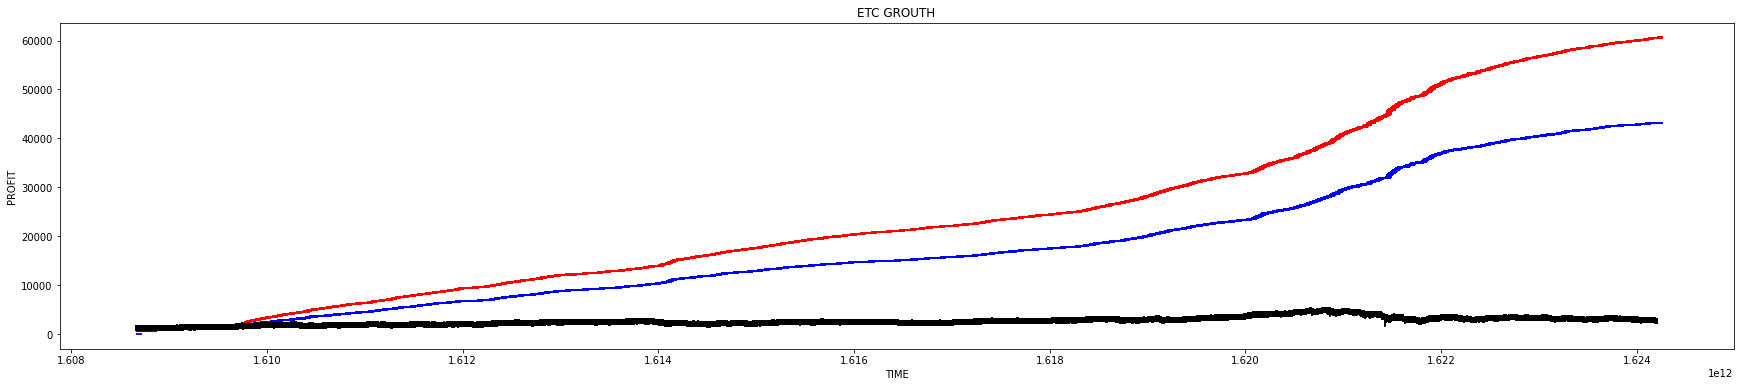

In [ ]:
#圖
plt.figure(figsize=(30, 6))
plt.title("ETC GROUTH") # title
plt.ylabel("PROFIT") # y label
plt.xlabel("TIME") # x label
plt.scatter(df_stock['openTime'], df_stock['5_5'],c='r', marker=1, label='5_5')
plt.scatter(df_stock['openTime'], df_stock['10_10'],c='blue', marker=1, label='10_10')
plt.scatter(df_stock['openTime'], df_stock['close'],c='black', marker=2, label='close')
plt.savefig('t.png')

### 根據規則比較API

In [ ]:
picture=plt.figure(figsize=(30, 6))
@app.route('/getEarn', methods=['POST'])
def getEarn():
  limit=['min5','min10','min30','1h','3h']
  timeLimit={3:12900,6:259200,12:518400,0:':'}

  stock={'btc':df_stock_btc,'etc':df_stock_etc,'doge':df_stock_doge}
  rJson = request.json

  #request data
  coin = rJson['coin']
  time = rJson['time']
  buyLimit = rJson['buyLimit']
  buyType = rJson['buyType']
  sellLimit = rJson['sellLimit']
  sellType = rJson['sellType']
  
  df_stock=stock[coin]

  #抓出時間範圍內 
  #設計參數
  buyStrategy = Strategy(buyType[0])
  sellStrategy = Strategy(sellType[0])
  buyPrice=df_stock[limit[buyLimit[0]]]
  sellPrice=df_stock[limit[sellLimit[0]]]
  nowPrice=(df_stock['close']+df_stock['open'])/2


  extraBuyPrice=df_stock['min5']
  extraSellPrice=df_stock['min10']
  if(len(buyLimit)==2 and buyLimit[1]==5):
    extraBuyStrategy = ExtraStrategy(buyType[1])
  else:
    extraBuyStrategy = ExtraStrategy(-1)

  if(len(sellLimit)==2 and sellLimit[1]==5):
    extraSellStrategy = ExtraStrategy(sellType[1])
  else:
    extraSellStrategy = ExtraStrategy(-1)

  df_stock['bankPrice']= stategyForMA(buyPrice,sellPrice,nowPrice,buyStrategy,sellStrategy,extraBuyPrice,extraSellPrice,extraBuyStrategy,extraSellStrategy)
  the_stock=df_stock
  #按照策略計算
  
  #輸出
  before=df_stock['bankPrice'][1]
  after=df_stock['bankPrice'].iloc[-1]
  StrategyRate=round(((after-before)/before)*100+1,2)

  before1=df_stock['bankPrice'][1]
  after1=df_stock['close'].iloc[-1]
  NormalRate=round(((after1-before1)/before1)*100+1,2)

  diffRate=str(round((after/after1),2))+'倍額外獲利率'
  
  #圖
  plt.figure(figsize=(30, 6))
  plt.ylabel('totalMoney')
  plt.scatter(the_stock['openTime'], the_stock['bankPrice'],c='r', marker=1, label='Profitable')
  plt.scatter(the_stock['openTime'], the_stock['close'],c='black', marker=2, label='Stock')
  plt.savefig('t.png')

  # with open("/content/drive/MyDrive/CloudProJ/t.png", 'rb') as img_f:
  #   img_stream = img_f.read()
  #   img_stream = base64.b64encode(img_stream)


  r={  
      'normalRate':NormalRate,
      'StrategyRate': StrategyRate,
      'diffRate':diffRate
  }
  return json.dumps(r)


### 抓取結果比較圖片API

In [ ]:
@app.route('/pic', methods=['GET'])
def pic():

  with open("/content/drive/MyDrive/CloudProJ/t.png", 'rb') as img_f:
      img_stream = img_f.read()
      img_stream = base64.b64encode(img_stream)

  return img_stream
app.run()

In [ ]:
import time
import threading


def createTimer():
    t = threading.Timer(2, repeat)
    t.start()
    

def repeat():
    print('Now:', time.strftime('%H:%M:%S',time.localtime()))
    createTimer()
    
    
createTimer()